In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

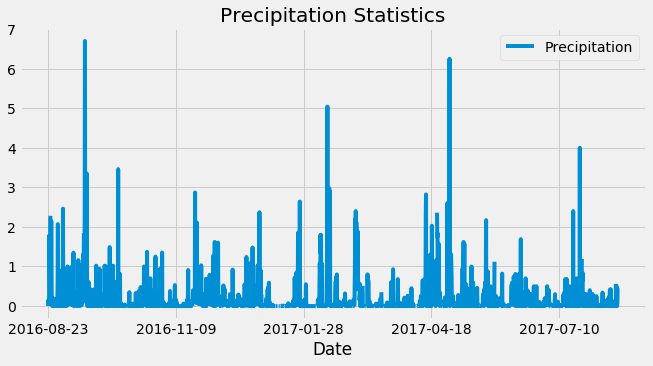

In [10]:
# Calculate the date 1 year ago from the last data point in the database
# last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

# Design a query to retrieve the last 12 months of precipitation data *select only 'date' and 'prcp' values
prcp_data = session.\
    query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).\
    all()

# Perform a query to retrieve the data and precipitation scores
all_scores = session.\
    query(Measurement.date, Measurement.prcp).\
    order_by(Measurement.date.desc()).\
    all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data, columns = ["Date", "Precipitation"])

# Sort the dataframe by date
prcp_df.set_index("Date", inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title = "Precipitation Statistics", figsize = (10, 5))
plt.legend(loc = "upper right")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
station_count = session.\
    query(Measurement.station).\
    distinct().\
    count()
station_count

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.\
    query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).\
    desc()).\
    all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)]

min_max_avg_temp = session.\
    query(*sel).\
    filter(Measurement.station == "USC00519281").\
    all()
min_max_avg_temp

[(54.0, 85.0, 71.66378066378067)]

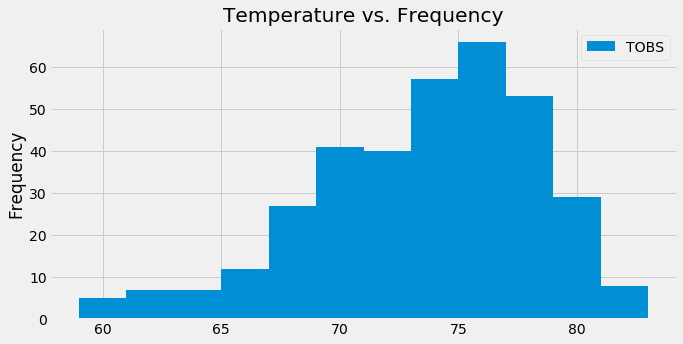

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_tobs = session.\
    query(Measurement.tobs).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).\
    all()

# Save the query results as a Pandas DataFrame
highest_tobs_df = pd.DataFrame(highest_tobs, columns = ["TOBS"])

# Use Pandas Plotting with Matplotlib to plot the data
highest_tobs_df.plot.hist(bins = 12, title = "Temperature vs. Frequency", figsize = (10, 5))
plt.legend(loc = "upper right")
plt.show()

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.\
        query(func.min(Measurement.tobs),
              func.avg(Measurement.tobs),
              func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).\
        all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]
